In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pathlib import Path
import nolds

sns.set_style("whitegrid")
sns.set_context("notebook")
sns.set_palette("muted")
%matplotlib inline

DATA_PATH = Path("../data/processed/double_pendulum_processed.csv")
PLOT_DIR = Path("../plots")

In [26]:
if not DATA_PATH.exists():
    raise FileNotFoundError(f"❌ Processed data not found at: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
df.head()

,time,theta1,theta2,omega1,omega2,x1,y1,x2,y2,KE,PE,TME
0,0.00,2.094395,-0.174533,0.000000,0.000000,0.866025,0.500000,0.692377,-0.484808,0.000000,29.579036,29.579036
1,0.01,2.093894,-0.174296,-0.100185,0.047317,0.866276,0.499566,0.692861,-0.485283,0.014201,29.570121,29.584322
2,0.02,2.092391,-0.173588,-0.200410,0.094385,0.867026,0.498264,0.694308,-0.486708,0.056734,29.543363,29.600098
3,0.03,2.089886,-0.172411,-0.300715,0.140950,0.868271,0.496090,0.696713,-0.489084,0.127392,29.498728,29.626120
4,0.04,2.086377,-0.170773,-0.401144,0.186767,0.870007,0.493040,0.700063,-0.492414,0.225836,29.436146,29.661983


In [27]:
g = 9.81
L1 = L2 = 1.0
m1 = m2 = 1.0

def derivatives(t, y):
    θ1, θ2, ω1, ω2 = y
    Δ = θ2 - θ1
    denom = (2*m1 + m2 - m2 * np.cos(2*Δ))

    dω1_dt = (
        -g*(2*m1 + m2)*np.sin(θ1)
        - m2*g*np.sin(θ1 - 2*θ2)
        - 2*np.sin(Δ)*m2*(ω2**2*L2 + ω1**2*L1*np.cos(Δ))
    ) / (L1 * denom)

    dω2_dt = (
        2*np.sin(Δ) * (
            ω1**2 * L1 * (m1 + m2)
            + g * (m1 + m2) * np.cos(θ1)
            + ω2**2 * L2 * m2 * np.cos(Δ)
        )
    ) / (L2 * denom)

    return [ω1, ω2, dω1_dt, dω2_dt]

In [28]:
theta1_0 = df["theta1"].iloc[0]
theta2_0 = df["theta2"].iloc[0]
omega1_0 = df["omega1"].iloc[0]
omega2_0 = df["omega2"].iloc[0]

t_eval = df["time"].values
t_start, t_end = t_eval[0], t_eval[-1]

delta = 1e-6
initial_perturbed = [theta1_0 + delta, theta2_0, omega1_0, omega2_0]

sol_perturbed = solve_ivp(
    derivatives,
    [t_start, t_end],
    initial_perturbed,
    t_eval=t_eval,
    method="RK45"
)


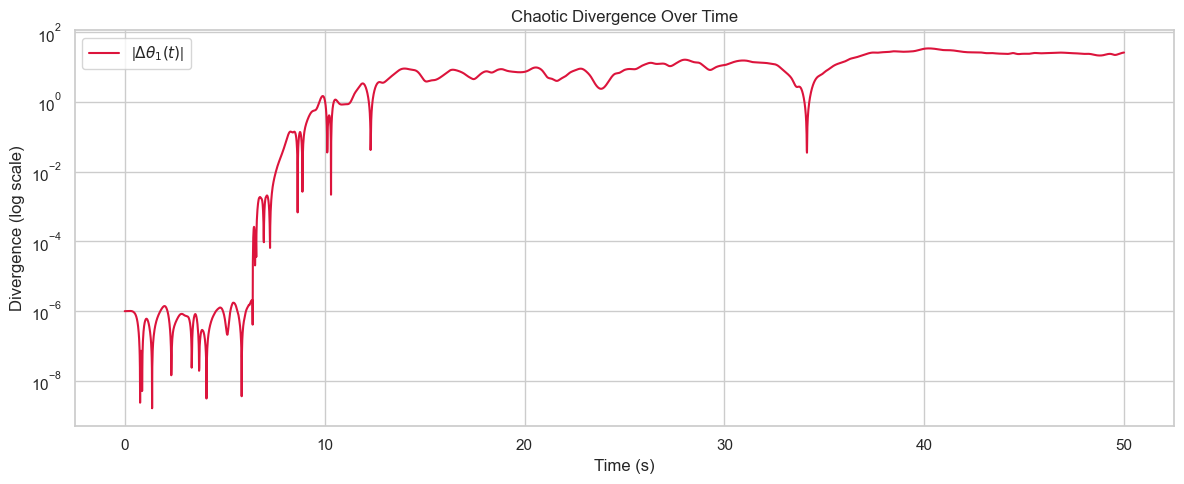

✅ Saved: ..\plots\divergence_plot.png


In [29]:
original_theta1 = df["theta1"].values
perturbed_theta1 = sol_perturbed.y[0]

divergence = np.abs(original_theta1 - perturbed_theta1)
divergence[divergence == 0] = 1e-20  

plt.figure(figsize=(12, 5))
sns.lineplot(x=t_eval, y=divergence, color="crimson", label=r"|$\Delta\theta_1(t)$|")
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Divergence (log scale)")
plt.title("Chaotic Divergence Over Time")
plt.legend()
plt.tight_layout()

divergence_plot = PLOT_DIR / "divergence_plot.png"
plt.savefig(divergence_plot, dpi=300)
plt.show()

print(f"✅ Saved: {divergence_plot}")

In [30]:
lyap = nolds.lyap_r(
    original_theta1,
    emb_dim=10,
    lag=50,
    min_tsep=100
)

print(f"Estimated Largest Lyapunov Exponent: {lyap:.4f}")


Estimated Largest Lyapunov Exponent: 0.0025


In [31]:
m1 = m2 = 1.0
l1 = l2 = 1.0
g = 9.81
t_span = (0, 20)
n_steps = 50_000
t_eval = np.linspace(*t_span, n_steps)

In [32]:
def double_pendulum_ode(t, y, m1, m2, l1, l2, g):
    θ1, ω1, θ2, ω2 = y
    Δ = θ2 - θ1

    den1 = (m1 + m2) * l1 - m2 * l1 * np.cos(Δ)**2
    den2 = (l2 / l1) * den1

    dydt = np.zeros_like(y)
    dydt[0] = ω1
    dydt[1] = (
        m2 * l1 * ω1**2 * np.sin(Δ) * np.cos(Δ)
        + m2 * g * np.sin(θ2) * np.cos(Δ)
        + m2 * l2 * ω2**2 * np.sin(Δ)
        - (m1 + m2) * g * np.sin(θ1)
    ) / den1
    dydt[2] = ω2
    dydt[3] = (
        -m2 * l2 * ω2**2 * np.sin(Δ) * np.cos(Δ)
        + (m1 + m2) * g * np.sin(θ1) * np.cos(Δ)
        - (m1 + m2) * l1 * ω1**2 * np.sin(Δ)
        - (m1 + m2) * g * np.sin(θ2)
    ) / den2
    return dydt

In [33]:
y0_main = [np.pi / 2, 0, np.pi / 2, 0]
y0_perturbed = [np.pi / 2 + 1e-6, 0, np.pi / 2, 0]

In [34]:
sol_main = solve_ivp(double_pendulum_ode, t_span, y0_main, t_eval=t_eval, args=(m1, m2, l1, l2, g), rtol=1e-9, atol=1e-9)
sol_perturbed = solve_ivp(double_pendulum_ode, t_span, y0_perturbed, t_eval=t_eval, args=(m1, m2, l1, l2, g), rtol=1e-9, atol=1e-9)

In [35]:
θ1_main, θ2_main = sol_main.y[0], sol_main.y[2]
θ1_pert, θ2_pert = sol_perturbed.y[0], sol_perturbed.y[2]

t = sol_main.t[:len(divergence)]

In [36]:
df_div = pd.DataFrame({
    "time": t,
    "divergence": divergence,
    "log_divergence": np.log(divergence + 1e-12)  # avoid log(0)
})

In [37]:
output_path = Path("../data/processed/divergence_analysis.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)
df_div.to_csv(output_path, index=False)
print(f"✅ Divergence data saved to: {output_path}")

✅ Divergence data saved to: ..\data\processed\divergence_analysis.csv


In [ ]:
t_div = sol_main.t[:len(divergence)]

plt.figure(figsize=(12, 6))
plt.plot(t_div, divergence, label="Divergence", color="crimson")
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Divergence (log scale)")
plt.title("Exponential Divergence in Double Pendulum (Chaos)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (50000,) and (5000,)